In [1]:
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/code/src')
from skrgbd.calibration.camera_models.central_generic import CentralGeneric
from skrgbd.data.processing.processing_pipeline.depth.data_loaders import Loader, WallDataset
from skrgbd.calibration.depth_distortion_models import PixBatchUvDUndistortionModel, save_to_pt
from skrgbd.data.dataset.scene_paths import ScenePaths
from skrgbd.utils.logging import tqdm
from skrgbd.data.dataset.dataset import wip_scene_id_by_name

In [2]:
cam = 'real_sense'

scene_paths = ScenePaths(None, aux_dir='/data/aux', data_dir='/data/dataset')
device, dtype = 'cuda', torch.double

### Load data

In [3]:
cam_model = scene_paths.cam_model(cam, 'ir', 'generic')
cam_model = CentralGeneric(cam_model, dtype=dtype)

train_data = f'/data/calibration/raw_calibration/depth_wall_{cam}/{cam}_tensor.npy'
train_data = WallDataset(train_data, cam_model)

  0%|          | 0/7777 [00:00<?, ?it/s]

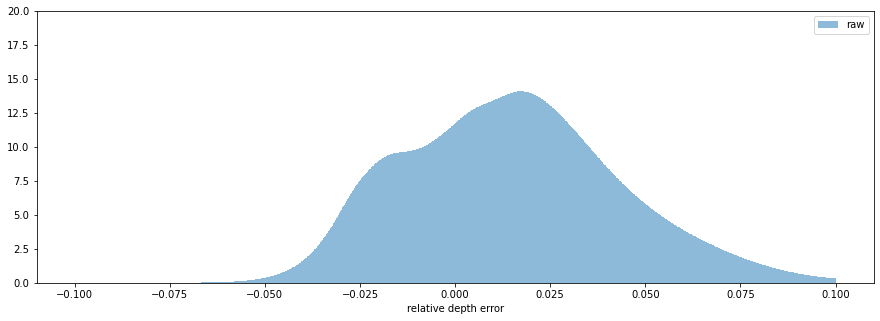

In [4]:
if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()

def get_resids(sl_d, d):
    res = d.div(sl_d)
    res = res[res.isfinite()].sub_(1)
    return res

raw_resids = []

train_loader = Loader(train_data, batch_size=2**20, shuffle=False)
for uv, raw_d, sl_d in tqdm(train_loader):
    del uv
    raw_d = raw_d.to(device, dtype)
    sl_d = sl_d.to(device, dtype)
    raw_resids.append(get_resids(sl_d, raw_d).cpu()); del sl_d, raw_d
del train_loader
raw_resids = torch.cat(raw_resids)


plt.figure(figsize=(15, 5))
kwargs = dict(bins=1000, range=(-.1, .1), alpha=.5, density=True)

plt.hist(raw_resids.numpy(), label='raw', **kwargs); del raw_resids
plt.legend()
plt.gca().set_xlabel('relative depth error');
plt.ylim(0, 20);

### Set limits for UV and depth values

In [5]:
min_uv, max_uv = train_data.uv.min(0)[0], train_data.uv.max(0)[0]
min_d, max_d = torch.tensor([.5]), torch.tensor([1.3])

step_uv = torch.tensor([40, 40])
step_d = torch.tensor([.1])

### Define interpolation cells with enough training data

In [6]:
undist_model = PixBatchUvDUndistortionModel.from_sizes(min_uv, max_uv, step_uv, min_d, max_d, step_d)

Discard out-of-bounds training points.

In [7]:
uv = train_data.uv
u_ids, v_ids = undist_model.uv_spline.get_cell_ids(uv).unbind(1); del uv

raw_d = train_data.raw_d
d_ids = undist_model.d_spline.get_cell_ids(raw_d.unsqueeze(-1)).squeeze(-1); del raw_d

is_in_bounds = (u_ids != -1).logical_and_(v_ids != -1).logical_and_(d_ids != -1)
u_ids = u_ids[is_in_bounds]
v_ids = v_ids[is_in_bounds]
d_ids = d_ids[is_in_bounds]

all_pts_n = len(is_in_bounds); del is_in_bounds
oob_pts_n = all_pts_n - len(u_ids)

print(f'Discarding {oob_pts_n} / {all_pts_n}, i.e {oob_pts_n * 100 / all_pts_n:.2}% OOB points.')

Discarding 580045722 / 8154402800, i.e 7.1% OOB points.


Calculate distribution of training points across cells.

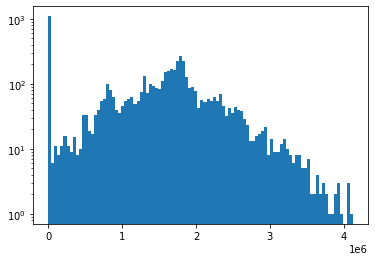

In [8]:
all_pts_n = len(u_ids)

hist = torch.zeros_like(undist_model.cell_is_calib, dtype=torch.long)
vals = hist.new_ones(1).expand(all_pts_n)
hist.index_put_([u_ids, v_ids, d_ids], vals, accumulate=True); del u_ids, v_ids, d_ids, vals

plt.hist(hist.ravel().cpu().numpy(), 100)
plt.yscale('log')

Define calibrated cells with enough training points.

In [9]:
min_pts_n_per_cell = 1000

cell_is_calib = hist >= min_pts_n_per_cell

discarded_pts_n = hist[~cell_is_calib].sum()
print(f'Discarding {discarded_pts_n} / {all_pts_n}, i.e {(discarded_pts_n / all_pts_n) *  100:.2}% points.')

cells_n = cell_is_calib.numel()
calib_cells_n = cell_is_calib.sum().item()
print(f'Calibrated cells {calib_cells_n} / {cells_n}.')

Discarding 196 / 7574357078, i.e 2.6e-06% points.
Calibrated cells 4571 / 5643.


### Train model

  0%|          | 0/31107 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x1553ff6f2820>
Traceback (most recent call last):
  File "/code/src/skrgbd/utils/logging/_tqdm.py", line 37, in __del__
    self._logger.handlers[0] = self._default_handler
AttributeError: 'tqdm' object has no attribute '_default_handler'


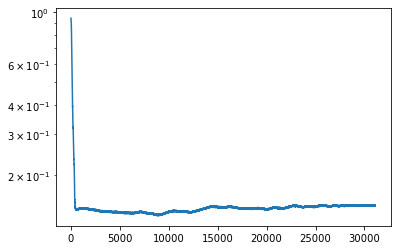

In [10]:
if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()

train_loader = Loader(train_data, batch_size=2**18, shuffle=True)

undist_model = PixBatchUvDUndistortionModel.from_sizes(min_uv, max_uv, step_uv, min_d, max_d, step_d)
undist_model.cell_is_calib.data.copy_(cell_is_calib)
undist_model = undist_model.to(device, dtype).requires_grad_(True)


def fit_model(epochs_n=1, lr=1e-3):
    optim = torch.optim.Adam([*undist_model.parameters()], lr=lr)
    train_costs = []
    for epoch_i in range(epochs_n):
        for uv, raw_d, sl_d in tqdm(train_loader):
            uv = uv.to(device, dtype)
            raw_d = raw_d.to(device, dtype)
            sl_d = sl_d.to(device, dtype)
            def closure():
                optim.zero_grad()
                d = undist_model(uv, raw_d.unsqueeze(1))
                cost = cost_fn(sl_d, d)
                cost.backward()
                train_costs.append(float(cost))
                return cost
            optim.step(closure); del uv, raw_d, sl_d
    return train_costs


def cost_fn(sl_d, d):
    res = d.div_(sl_d)
    res = res[res.isfinite()].sub_(1)
    cost = welsch(res, .05 / 3)
    return cost


def welsch(res, c):
    res = res.div(c).pow_(2).div_(-2)
    res = res.expm1_().neg()
    res = res.mean()
    return res


train_costs = fit_model(epochs_n=1, lr=1e-3)
plt.plot(train_costs)
plt.yscale('log')

### Check distribution of errors

In [11]:
if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()
undist_model = undist_model.requires_grad_(False)

def get_resids(sl_d, d):
    res = d.div(sl_d)
    res = res[res.isfinite()].sub_(1)
    return res

raw_resids = []
undist_resids = []

train_loader = Loader(train_data, batch_size=2**20, shuffle=False)
for uv, raw_d, sl_d in tqdm(train_loader):
    uv = uv.to(device, dtype)
    raw_d = raw_d.to(device, dtype)
    sl_d = sl_d.to(device, dtype)
    raw_resids.append(get_resids(sl_d, raw_d).cpu())
    d = undist_model(uv, raw_d.unsqueeze(1)); del uv, raw_d
    undist_resids.append(get_resids(sl_d, d).cpu()); del d, sl_d
raw_resids = torch.cat(raw_resids)
undist_resids = torch.cat(undist_resids)

  0%|          | 0/7777 [00:00<?, ?it/s]

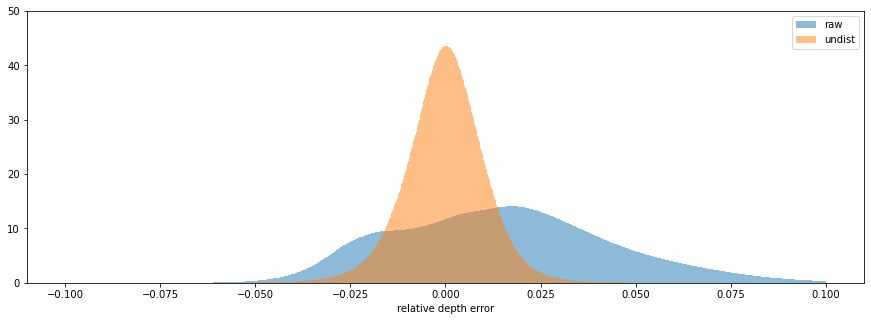

In [12]:
plt.figure(figsize=(15, 5))
kwargs = dict(bins=1000, range=(-.1, .1), alpha=.5, density=True)

plt.hist(raw_resids.numpy(), label='raw', **kwargs)
plt.hist(undist_resids.numpy(), label='undist', **kwargs)
plt.legend()
plt.gca().set_xlabel('relative depth error');
plt.ylim(0, 50);

### Save model

In [13]:
undist_model_pt = scene_paths.undist_model(cam, 'depth', 'wall')
Path(undist_model_pt).parent.mkdir(exist_ok=True, parents=True)
save_to_pt(undist_model_pt, undist_model)